# Constraint based analysis

We will analyse contraint-based models of the form

\begin{equation}
    \max_{v^0} c^T \cdot v \\
    s.t. N \cdot v^0 = 0 \\
    \alpha_i \leq v_i^0 \leq \beta_i
\end{equation}

using `cobrapy`.

Information in this tutorial is based on 
https://cobrapy.readthedocs.io/en/latest/

In [1]:
%matplotlib inline

## 1. Working with metabolic models
### 1.1 Loading model and inspecting it
To begin with, cobrapy comes with bundled models for *Salmonella* and *E. coli*, as well as a “textbook” model of E. coli core metabolism. To load a test model, type

In [4]:
import cobra
import cobra.test

# "ecoli" and "salmonella" are also valid arguments
model = cobra.test.create_test_model("textbook")

The reactions, metabolites, and genes attributes of the cobrapy model are a special type of list called a `cobra.DictList`, and each one is made up of `cobra.Reaction`, `cobra.Metabolite` and `cobra.Gene` objects respectively.

In [5]:
print(len(model.reactions))
print(len(model.metabolites))
print(len(model.genes))

95
72
137


When using Jupyter notebook this type of information is rendered as a table.

In [6]:
model

Name,e_coli_core
Memory address,0x07f340c5a5550
Number of metabolites,72
Number of reactions,95
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


Just like a regular list, objects in the `DictList` can be retrieved by index. For example, to get the 30th reaction in the model (at index 29 because of 0-indexing):

In [8]:
model.reactions[29]

Reaction identifier,EX_glu__L_e
Name,L-Glutamate exchange
Memory address,0x07f333810f128
Stoichiometry,glu__L_e --> L-Glutamate -->
GPR,
Lower bound,0.0
Upper bound,1000.0


Additionally, items can be retrieved by their `id` using the `DictList.get_by_id()` function. For example, to get the cytosolic atp metabolite object (the id is “atp_c”), we can do the following:

In [9]:
model.metabolites.get_by_id("atp_c")

Metabolite identifier,atp_c
Name,ATP
Memory address,0x07f33381c4ef0
Formula,C10H12N5O13P3
Compartment,c
In 13 reaction(s),"GLNS, ATPS4r, PYK, ACKr, ADK1, PGK, ATPM, SUCOAS, PFK, Biomass_Ecoli_core, PPS, PPCK, GLNabc"


### 1.2 Reactions
We will consider the reaction glucose 6-phosphate isomerase, which interconverts glucose 6-phosphate and fructose 6-phosphate. The reaction id for this reaction in our test model is PGI.

In [11]:
pgi = model.reactions.get_by_id("PGI")
pgi

Reaction identifier,PGI
Name,glucose-6-phosphate isomerase
Memory address,0x07f33380e6b38
Stoichiometry,g6p_c <=> f6p_c D-Glucose 6-phosphate <=> D-Fructose 6-phosphate
GPR,b4025
Lower bound,-1000.0
Upper bound,1000.0


We can also ensure the reaction is mass balanced. This function will return elements which violate mass balance. If it comes back empty, then the reaction is mass balanced.

In [12]:
pgi.check_mass_balance()

{}

### 1.3 Metabolites

We will consider cytosolic atp as our metabolite, which has the id "atp_c" in our test model.

In [15]:
atp = model.metabolites.get_by_id("atp_c")
atp

Metabolite identifier,atp_c
Name,ATP
Memory address,0x07f33381c4ef0
Formula,C10H12N5O13P3
Compartment,c
In 13 reaction(s),"GLNS, ATPS4r, PYK, ACKr, ADK1, PGK, ATPM, SUCOAS, PFK, Biomass_Ecoli_core, PPS, PPCK, GLNabc"


### 1.4 Genes
The gene_reaction_rule is a boolean representation of the gene requirements for this reaction to be active as described in Schellenberger2011.

The GPR is stored as the gene_reaction_rule for a Reaction object as a string.

In [16]:
gpr = pgi.gene_reaction_rule
gpr

'b4025'

Corresponding gene objects also exist. These objects are tracked by the reactions itself, as well as by the model

In [17]:
pgi.genes

frozenset({<Gene b4025 at 0x7f333815df28>})

In [18]:
pgi_gene = model.genes.get_by_id("b4025")
pgi_gene

Gene identifier,b4025
Name,pgi
Memory address,0x07f333815df28
Functional,True
In 1 reaction(s),PGI


Each gene keeps track of the reactions it catalyzes

In [19]:
pgi_gene.reactions

frozenset({<Reaction PGI at 0x7f33380e6b38>})

## 1.5 Export as SBML & Visualization
The model can be exported to standard exchange formats, e.g., Systems Biology Markup Language (SBML) and be analyzed in other tools like for instance `Cytoscape` with `cy3sbml`

In [24]:
from cobra.io import write_sbml_model
write_sbml_model(model, "./models/e_coli_core.xml")

For instance after loading the model with `cy3sbml` we can get an overview over the metabolic network with the associated gene-product rules.
Note the typical hairball structure of biological networks due to highly connected nodes (cofactor metabolites).
<img src="./images/e_coli_core.png" width="1000"/>

### 2. Simulating with FBA

Simulations using flux balance analysis can be solved using Model.optimize(). This will maximize or minimize (maximizing is the default) flux through the objective reactions.

In [26]:
import cobra.test
model = cobra.test.create_test_model("textbook")
model

Name,e_coli_core
Memory address,0x07f333413cf98
Number of metabolites,72
Number of reactions,95
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


### 2.1. Running Flux Balance Analysis (FBA)

In [27]:
solution = model.optimize()
print(solution)

<Solution 0.874 at 0x7f3334173ac8>


The `Model.optimize()` function will return a Solution object. A solution object has several attributes:

- `objective_value`: the objective value
- `status`: the status from the linear programming solver
- `fluxes`: a pandas series with flux indexed by reaction identifier. The flux for a reaction variable is the difference of the primal values for the forward and reverse reaction variables.
- `shadow_prices`: a pandas series with shadow price indexed by the metabolite identifier.

For example, after the last call to `model.optimize()`, if the optimization succeeds it’s status will be optimal. In case the model is infeasible an error is raised.

#### 2.1.1. Analyzing FBA solutions

Models solved using FBA can be further analyzed by using summary methods, which output printed text to give a quick representation of model behavior. Calling the summary method on the entire model displays information on the input and output behavior of the model, along with the optimized objective.

In [28]:
model.summary()

In addition, the input-output behavior of individual metabolites can also be inspected using summary methods. For instance, the following commands can be used to examine the overall redox balance of the model

In [29]:
model.metabolites.nadh_c.summary()

Or to get a sense of the main energy production and consumption reactions

In [30]:
model.metabolites.atp_c.summary()

### 2.2 Changing the objectives
The objective function is determined from the objective_coefficient attribute of the objective reaction(s). Generally, a “biomass” function which describes the composition of metabolites which make up a cell is used.

In [43]:
biomass_rxn = model.reactions.get_by_id("Biomass_Ecoli_core")
biomass_rxn

Reaction identifier,Biomass_Ecoli_core
Name,Biomass Objective Function with GAM
Memory address,0x07f33edbb3cc0
Stoichiometry,1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c ... 1.496 3-Phospho-D-glycerate + 3.7478 Acetyl-CoA + 59.81 ATP + 0.361 D-Erythrose 4-phosphate + 0.0709 D-Fructose 6-phosphate + 0.129 Glyceraldehyde 3-phosphate + 0.205 D-Glucose 6-phosphate + 0.2557...
GPR,
Lower bound,0.0
Upper bound,1000.0


Currently in the model, there is only one reaction in the objective (the biomass reaction), with an linear coefficient of 1.

In [44]:
from cobra.util.solver import linear_reaction_coefficients
linear_reaction_coefficients(model)

{<Reaction Biomass_Ecoli_core at 0x7f33edbb3cc0>: 1.0}

The objective function can be changed by assigning Model.objective, which can be a reaction object (or just it’s name), or a dict of {Reaction: objective_coefficient}.

In [45]:
# change the objective to ATPM
model.objective = "ATPM"

# The upper bound should be 1000, so that we get
# the actual optimal value
model.reactions.get_by_id("ATPM").upper_bound = 1000.
linear_reaction_coefficients(model)

{<Reaction ATPM at 0x7f33edbb5e48>: 1.0}

In [46]:
model.optimize().objective_value

175.0

In [47]:
model.summary()

In [48]:
model.metabolites.atp_c.summary()

### 3.1. Running Flux Variability Analysis (FVA)

FBA will not give always give unique solution, because multiple flux states can achieve the same optimum. FVA (or flux variability analysis) finds the ranges of each metabolic flux at the optimum.

In [49]:
from cobra.flux_analysis import flux_variability_analysis
flux_variability_analysis(model, model.reactions[:10])

,minimum,maximum
ACALD,0.0,0.0
ACALDt,0.0,0.0
ACKr,0.0,0.0
ACONTa,20.0,20.0
ACONTb,20.0,20.0
ACt2r,0.0,0.0
ADK1,0.0,0.0
AKGDH,20.0,20.0
AKGt2r,0.0,0.0
ALCD2x,0.0,0.0


Setting parameter fraction_of_optimium=0.90 would give the flux ranges for reactions at 90% optimality.

In [50]:
cobra.flux_analysis.flux_variability_analysis(
    model, model.reactions[:10], fraction_of_optimum=0.9)

,minimum,maximum
ACALD,-2.692308,0.0
ACALDt,-2.692308,0.0
ACKr,-4.117647,0.0
ACONTa,8.461538,20.0
ACONTb,8.461538,20.0
ACt2r,-4.117647,0.0
ADK1,0.000000,17.5
AKGDH,2.500000,20.0
AKGt2r,-1.489362,0.0
ALCD2x,-2.333333,0.0


#### 3.1.1. Running FVA in summary methods
Flux variability analysis can also be embedded in calls to summary methods. For instance, the expected variability in substrate consumption and product formation can be quickly found by

In [51]:
model.optimize()
model.summary(fva=0.95)

### 4.1 Flux sampling

The easiest way to get started with flux sampling is using the sample function in the flux_analysis submodule. sample takes at least two arguments: a cobra model and the number of samples you want to generate.

In [59]:
from cobra.test import create_test_model
from cobra.sampling import sample

model = create_test_model("textbook")
s = sample(model, 500)
s.head()

,ACALD,ACALDt,ACKr,ACONTa,ACONTb,ACt2r,ADK1,AKGDH,AKGt2r,ALCD2x,...,RPI,SUCCt2_2,SUCCt3,SUCDi,SUCOAS,TALA,THD2,TKT1,TKT2,TPI
0,-0.282857,-0.277425,-0.443398,8.001667,8.001667,-0.443398,2.443677,4.955442,-0.038602,-0.005432,...,-3.856593,1.384137,2.506665,524.153344,-4.955442,3.752404,64.946022,3.752404,3.710505,5.934990
1,-1.190224,-0.943897,-0.714161,13.855737,13.855737,-0.714161,1.154312,4.172092,-0.278123,-0.246326,...,-1.318165,16.835203,17.695815,597.269255,-4.172092,1.294414,69.861528,1.294414,1.284863,8.653863
2,-2.965048,-1.638934,-2.856135,8.197135,8.197135,-2.856135,3.407190,3.474524,-0.271215,-1.326114,...,-1.429598,1.627893,1.948834,551.948015,-3.474524,1.358005,2.610168,1.358005,1.329215,8.414032
3,-1.995619,-0.421081,-3.261579,8.249347,8.249347,-3.261579,5.727441,4.245404,-0.150906,-1.574538,...,-1.644045,21.449819,23.917906,481.552677,-4.245404,1.597263,12.030915,1.597263,1.578450,7.963047
4,-2.446574,-0.776272,-3.600240,8.607713,8.607713,-3.600240,18.016170,4.678525,-0.032694,-1.670302,...,-1.369364,4.012122,4.284673,576.101839,-4.678525,1.354094,10.108491,1.354094,1.347953,7.649946


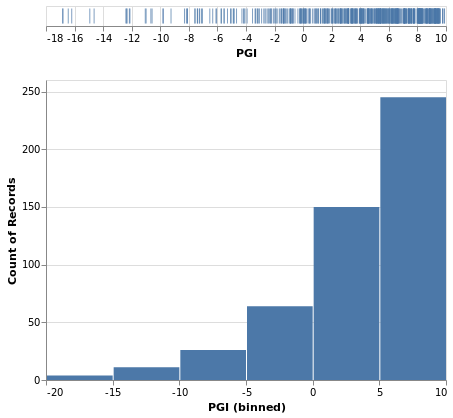

In [70]:
import altair as alt
p1 = alt.Chart(s).mark_tick().encode(
    x='PGI:Q',
)
p2 = alt.Chart(s).mark_bar().encode(
    alt.X('PGI:Q', bin=True),
    y='count()'
)
p1 & p2